In [1]:
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from skbio.stats.composition import clr
from sklearn.metrics import balanced_accuracy_score, make_scorer, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

plt.style.use("./paper.mplstyle")

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

md = pd.read_table("../data/tcga/processed/processed_md.tsv", sep="\t", index_col=0)
md["investigation"] = md["investigation"].str.replace("TCGA-", "")
print(md.shape)
invest_labels = pd.Series(
    LabelEncoder().fit_transform(md["investigation"]),
    index=md.index
)
center_labels = pd.Series(
    LabelEncoder().fit_transform(md["data_submitting_center_label"]),
    index=md.index
)

(1124, 41)


In [3]:
investigations = [x for x in md["investigation"].value_counts().index if x != "BRCA"]
len(investigations)

18

In [4]:
tbl = biom.load_table("../data/tcga/processed/species/processed_tbl.bacteria.biom")

In [5]:
tbl.shape

(1365, 1124)

In [6]:
centers = md["data_submitting_center_label"].unique()

center_pal = dict(zip(
    centers,
    sns.color_palette("colorblind", len(centers))
))

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/m

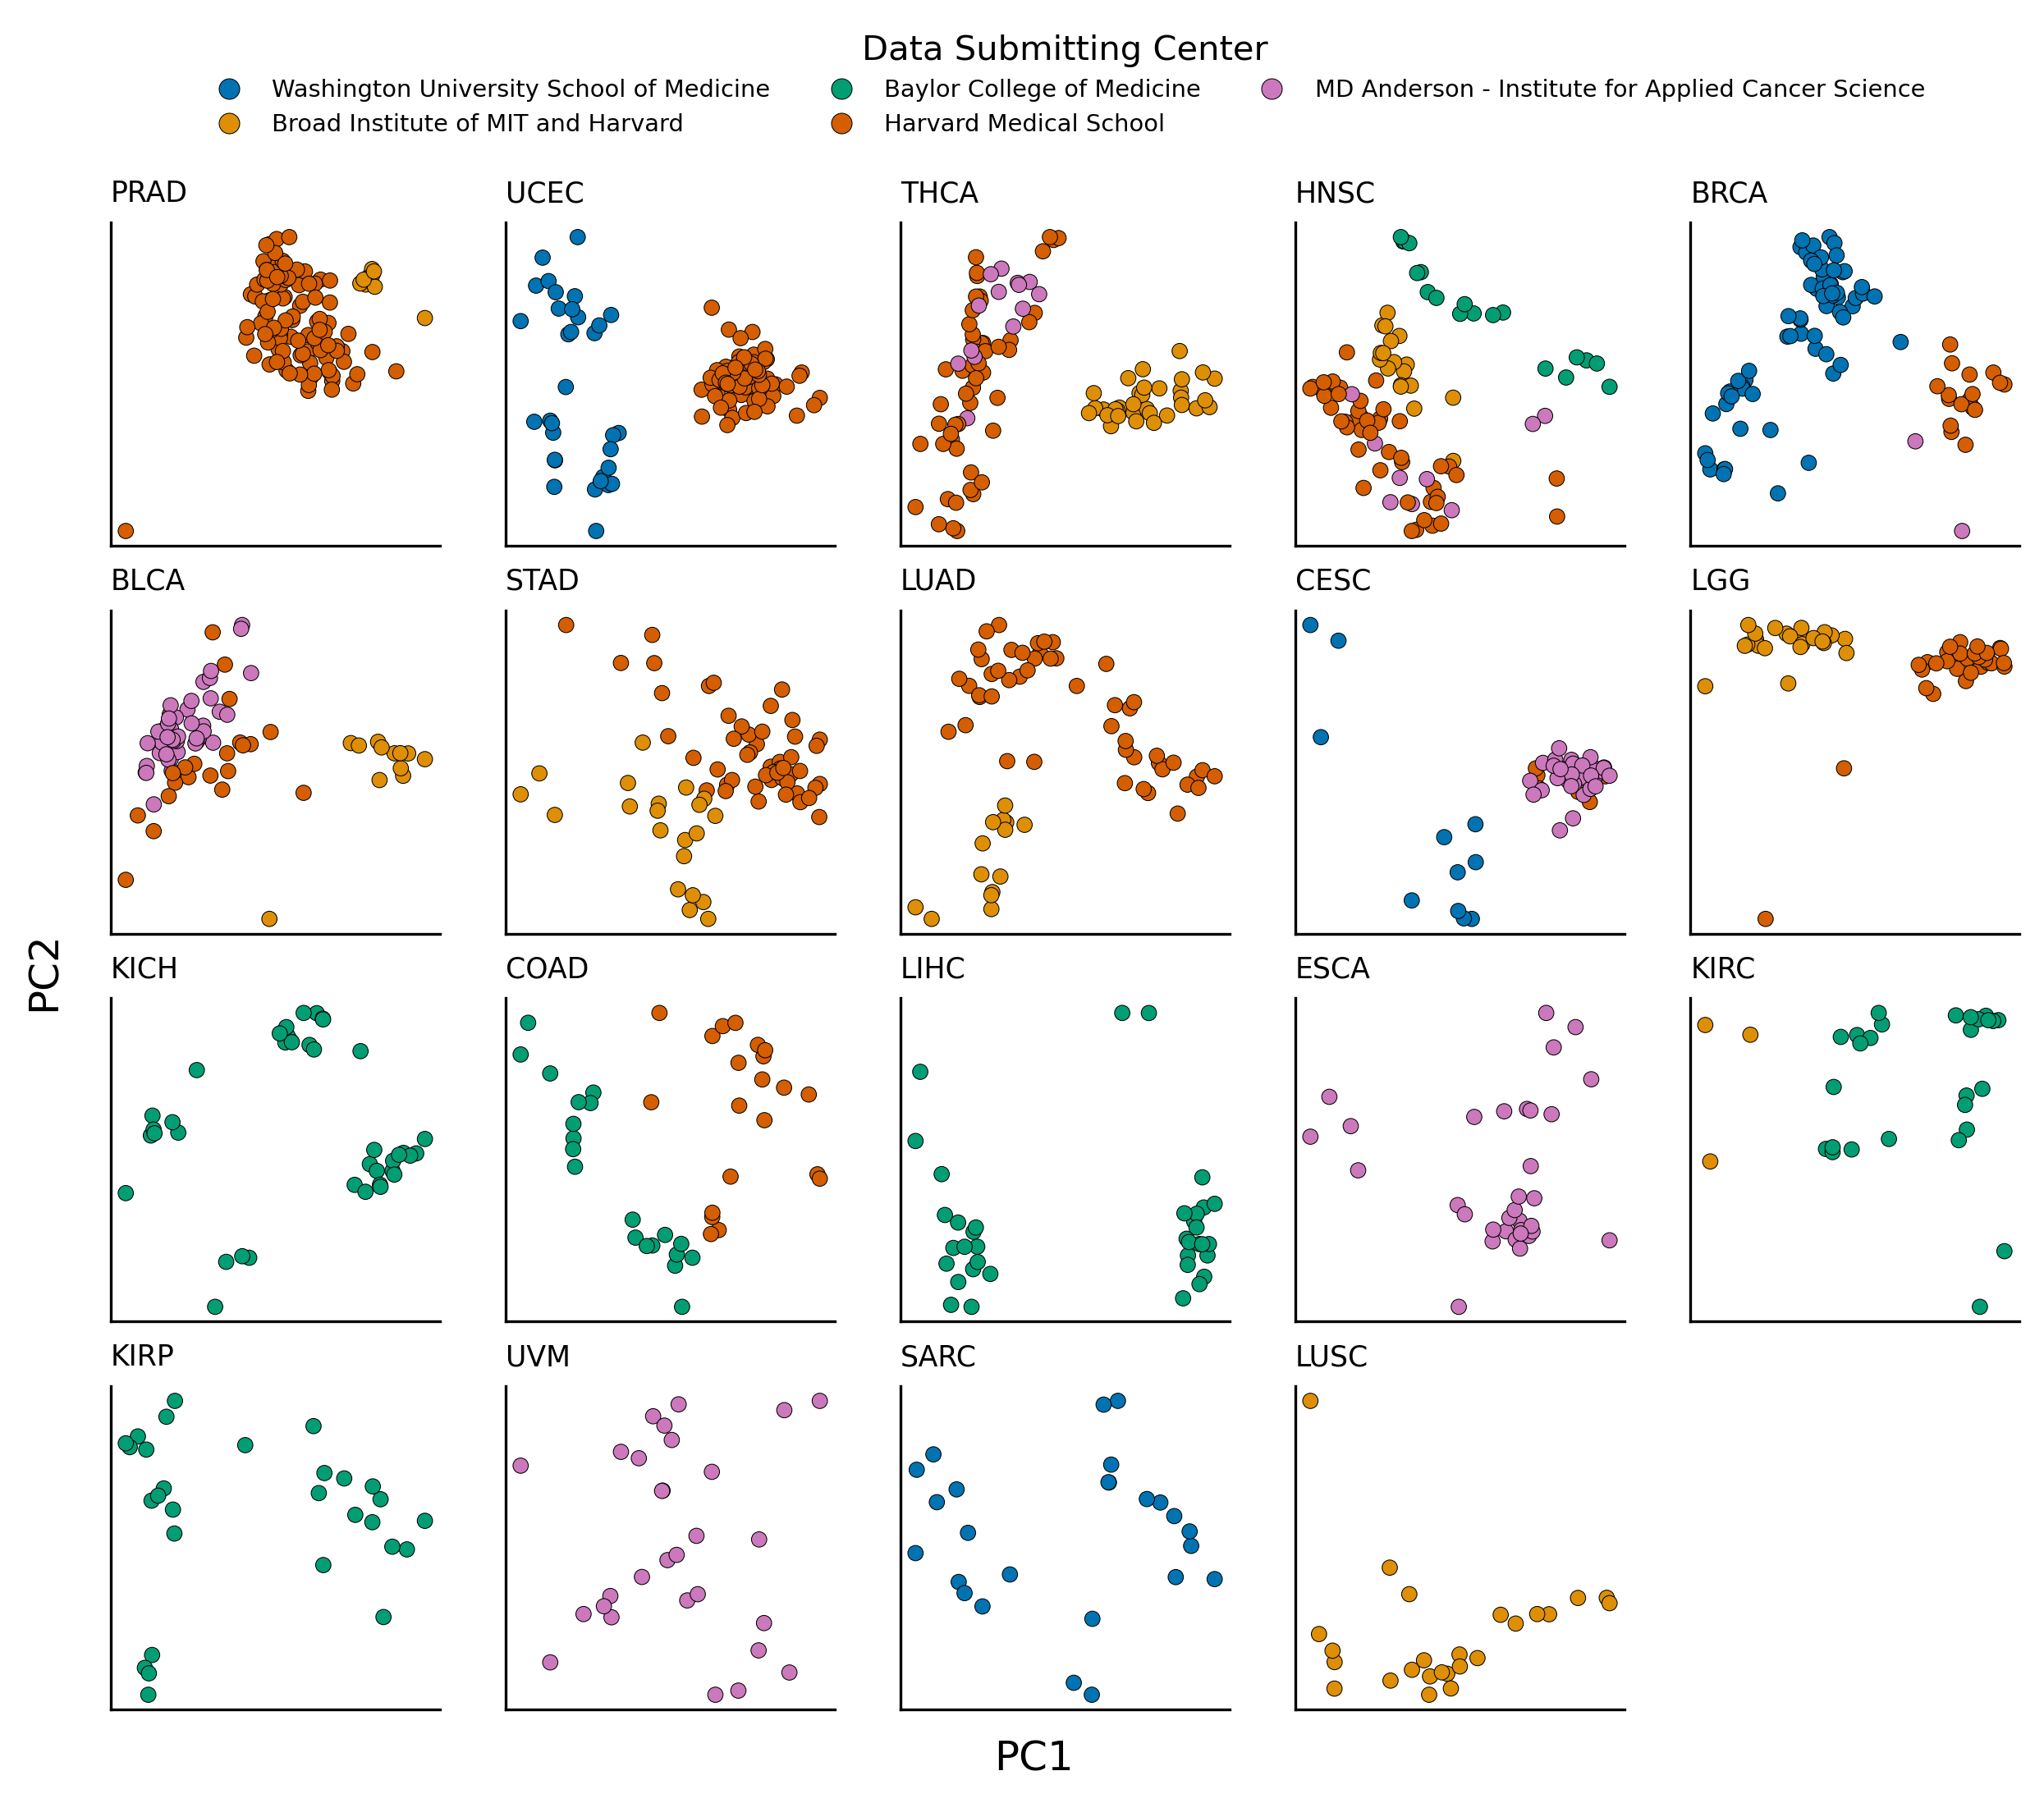

In [7]:
from gemelli.rpca import rpca

fig = plt.figure(figsize=(10, 8))
axs = []

for i, invest in enumerate(md["investigation"].value_counts().index, start=1):
    idx = md[md["investigation"] == invest].index
    tbl_filt = tbl.filter(idx, inplace=False)
    tbl_filt.remove_empty()
    
    ord_res, dm = rpca(tbl_filt)
    samp_axes = ord_res.samples.join(md, how="inner")
    
    ax = fig.add_subplot(4, 5, i)
    sns.scatterplot(
        data=samp_axes,
        x="PC1",
        y="PC2",
        hue="data_submitting_center_label",
        palette=center_pal,
        legend=False,
        linewidth=0.25,
        edgecolor="black",
        s=20,
        ax=ax
    )

    ax.set_title(invest, fontsize="small")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    axs.append(ax)
    
from matplotlib.lines import Line2D

handles = []
for center, color in center_pal.items():
    handle = Line2D([0], [0], color=color, label=center, marker="o",
                    lw=0, mew=0.25, mec="black")
    handles.append(handle)
    
axs[2].legend(
    handles=handles,
    ncol=3,
    loc="lower center",
    bbox_to_anchor=[0.5, 1.2],
    frameon=False,
    title="Data Submitting Center"
)

fig.supylabel("PC2", x=0.09)
fig.supxlabel("PC1", y=0.09)
    
plt.savefig("../figures/tcga/cancer_type_rpca.pdf")
plt.show()

In [8]:
import re

invest_reg = re.compile("\[T.TCGA-(\w+)\]_(mean|std)")

In [9]:
def rename_invest_cols(x):
    invest, agg_type = invest_reg.search(x).groups()
    return "_".join([invest, agg_type])

summ_diff_raw = pd.read_table("../results/tcga/species/birdman_results.bacteria.tsv", sep="\t", index_col=0)
summ_diff = summ_diff_raw.filter(like="TCGA")
summ_diff = summ_diff.rename(columns=rename_invest_cols)
summ_diff.index = summ_diff.index.astype(str)
summ_diff.head()

,BLCA_mean,CESC_mean,COAD_mean,ESCA_mean,HNSC_mean,KICH_mean,KIRC_mean,KIRP_mean,LGG_mean,LIHC_mean,...,LGG_std,LIHC_std,LUAD_std,LUSC_std,PRAD_std,SARC_std,STAD_std,THCA_std,UCEC_std,UVM_std
Feature,,,,,,,,,,,,,,,,,,,,,
G900499005,3.519366,-2.740362,-1.092949,4.285224,5.329091,-1.474053,-1.588916,-1.798797,-2.559276,-1.733899,...,3.020839,3.198119,1.960178,3.425180,2.788185,3.269329,1.832221,1.815179,1.742918,3.259464
G900065875,1.392127,2.637595,2.997600,4.304636,6.823291,-3.200641,0.952684,0.107036,-3.036432,-0.807957,...,2.825641,2.287738,2.554884,3.144933,1.739629,1.967071,1.650262,2.490340,1.401786,3.032100
G000174815,-1.558705,2.626543,0.810324,2.148961,7.099323,-1.048209,1.427819,0.355849,-3.998317,-0.014256,...,2.675985,2.195904,1.756522,2.120694,1.730337,1.925147,1.559962,1.690735,1.469910,2.957760
G000972495,-3.300048,-1.180943,1.365642,-2.858623,-1.248670,-0.404802,0.619611,0.410320,-2.067885,-2.165986,...,3.239188,2.254627,2.979796,3.169553,3.189664,1.924776,2.808369,2.062835,1.518983,3.296932
G000321005,5.106394,1.665152,1.357808,1.679604,3.557225,0.634298,0.320518,1.488633,-3.835284,-0.582865,...,2.619879,2.116244,1.832443,2.257756,1.887568,1.943499,1.652887,1.767627,1.464082,3.114847


In [10]:
summ_diff.shape

(1365, 36)

In [11]:
summ_diff_cent = summ_diff.filter(like="mean")
summ_diff_cent = summ_diff_cent.apply(lambda x: x - x.mean(), axis=0)
summ_diff_cent.head()

,BLCA_mean,CESC_mean,COAD_mean,ESCA_mean,HNSC_mean,KICH_mean,KIRC_mean,KIRP_mean,LGG_mean,LIHC_mean,LUAD_mean,LUSC_mean,PRAD_mean,SARC_mean,STAD_mean,THCA_mean,UCEC_mean,UVM_mean
Feature,,,,,,,,,,,,,,,,,,
G900499005,3.997763,-2.196628,-2.721057,4.072278,3.808048,-2.519490,-2.834272,-2.888523,-2.269650,-2.444414,3.959488,-1.602553,-1.838695,-1.586834,1.736510,0.687301,4.348312,0.307229
G900065875,1.870523,3.181330,1.369492,4.091690,5.302249,-4.246078,-0.292673,-0.982690,-2.746806,-1.518472,-3.177165,-1.993043,3.851968,1.310051,4.290791,-3.291890,0.319682,-0.310571
G000174815,-1.080309,3.170277,-0.817784,1.936015,5.578281,-2.093646,0.182463,-0.733877,-3.708691,-0.724771,0.935261,0.706706,2.571730,0.937851,4.108435,-1.757979,0.434006,-1.904256
G000972495,-2.821652,-0.637208,-0.262466,-3.071570,-2.769712,-1.450239,-0.625745,-0.679406,-1.778259,-2.876501,-1.806859,-1.879732,-0.035417,-0.629431,-3.545584,1.224097,1.573691,0.726321
G000321005,5.584790,2.208886,-0.270300,1.466658,2.036182,-0.411140,-0.924838,0.398907,-3.545658,-1.293380,0.699401,0.675407,-0.267532,0.942941,-0.030261,-0.868139,0.644309,-0.733837


/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


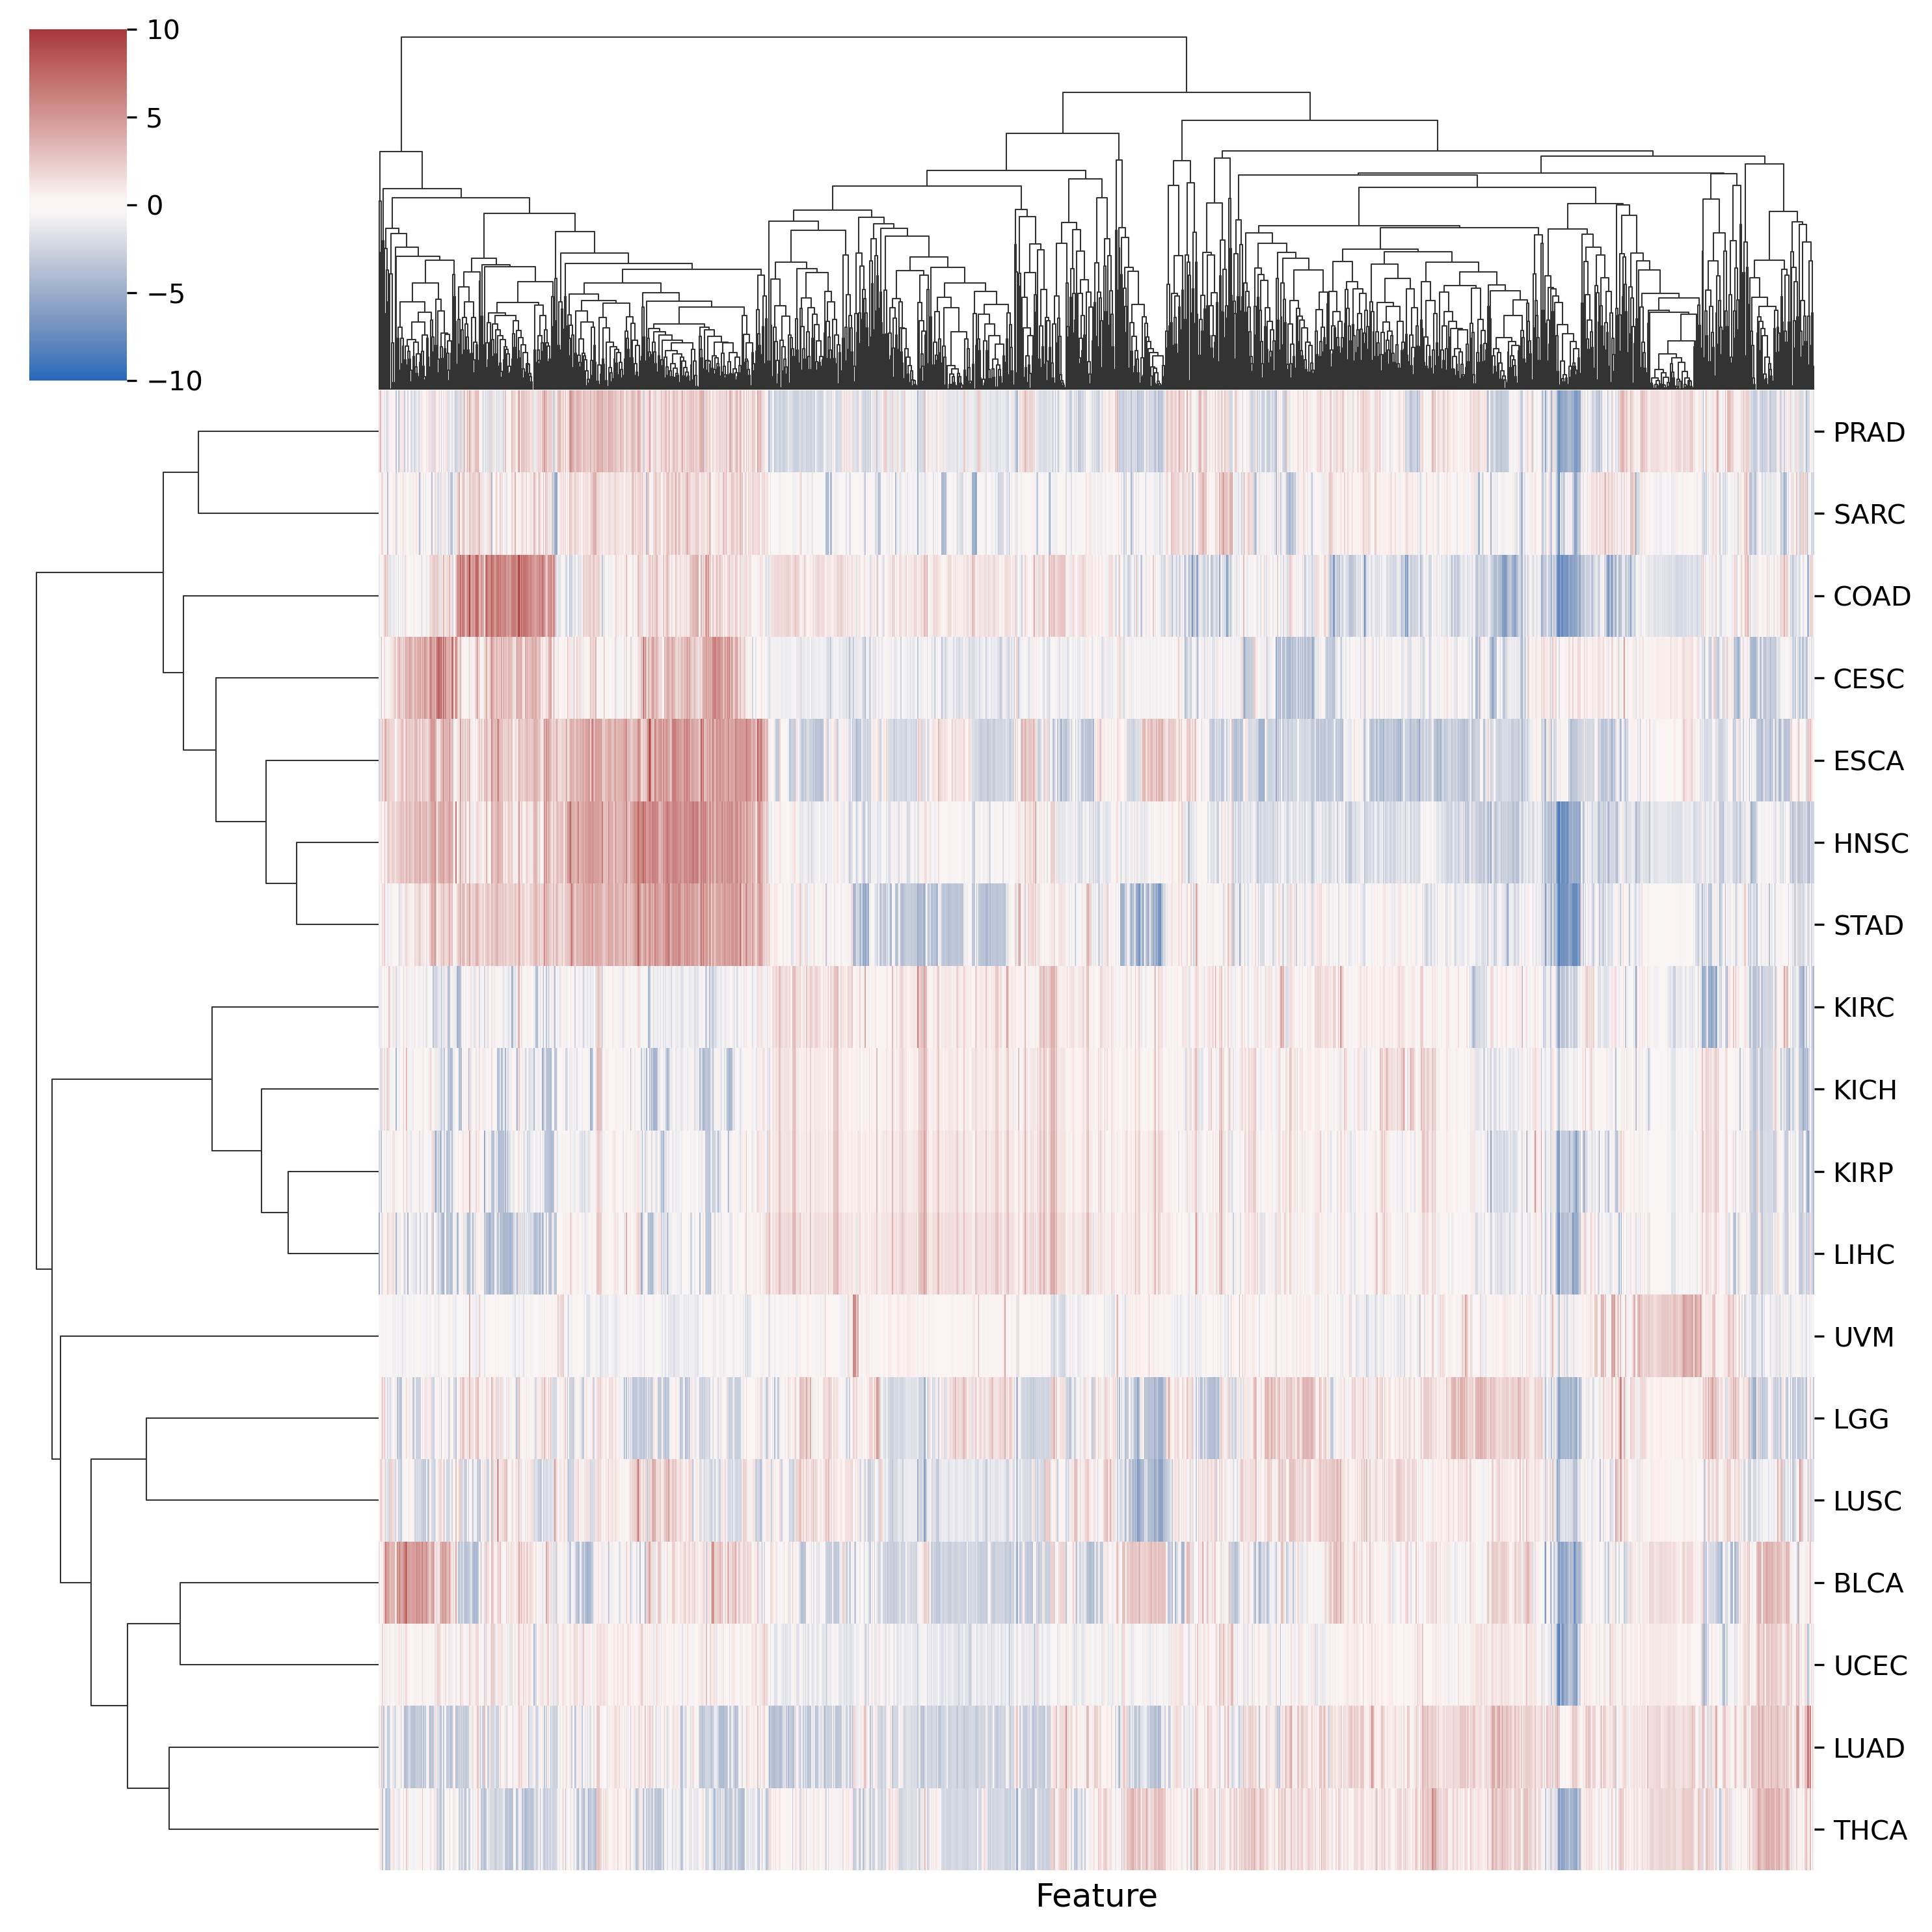

In [12]:
sns.clustermap(
    summ_diff_cent.T.rename(index=lambda x: x.replace("_mean", "")),
    cmap="vlag",
    center=0,
    metric="correlation",
    xticklabels=False,
    vmin=-10,
    vmax=10
)

plt.savefig("../figures/tcga/cancer_diff_clustermap.pdf")
plt.show()

In [13]:
corr = summ_diff_cent.corr("kendall")
corr.index = [x.replace("_mean", "") for x in corr.index]
corr.columns = [x.replace("_mean", "") for x in corr.columns]
mask = np.zeros_like(corr)
np.fill_diagonal(mask, 1)

corr.iloc[:5, :5]

,BLCA,CESC,COAD,ESCA,HNSC
BLCA,1.000000,0.163529,-0.003811,0.124727,0.128336
CESC,0.163529,1.000000,0.130330,0.323762,0.295292
COAD,-0.003811,0.130330,1.000000,0.234052,0.402249
ESCA,0.124727,0.323762,0.234052,1.000000,0.480197
HNSC,0.128336,0.295292,0.402249,0.480197,1.000000


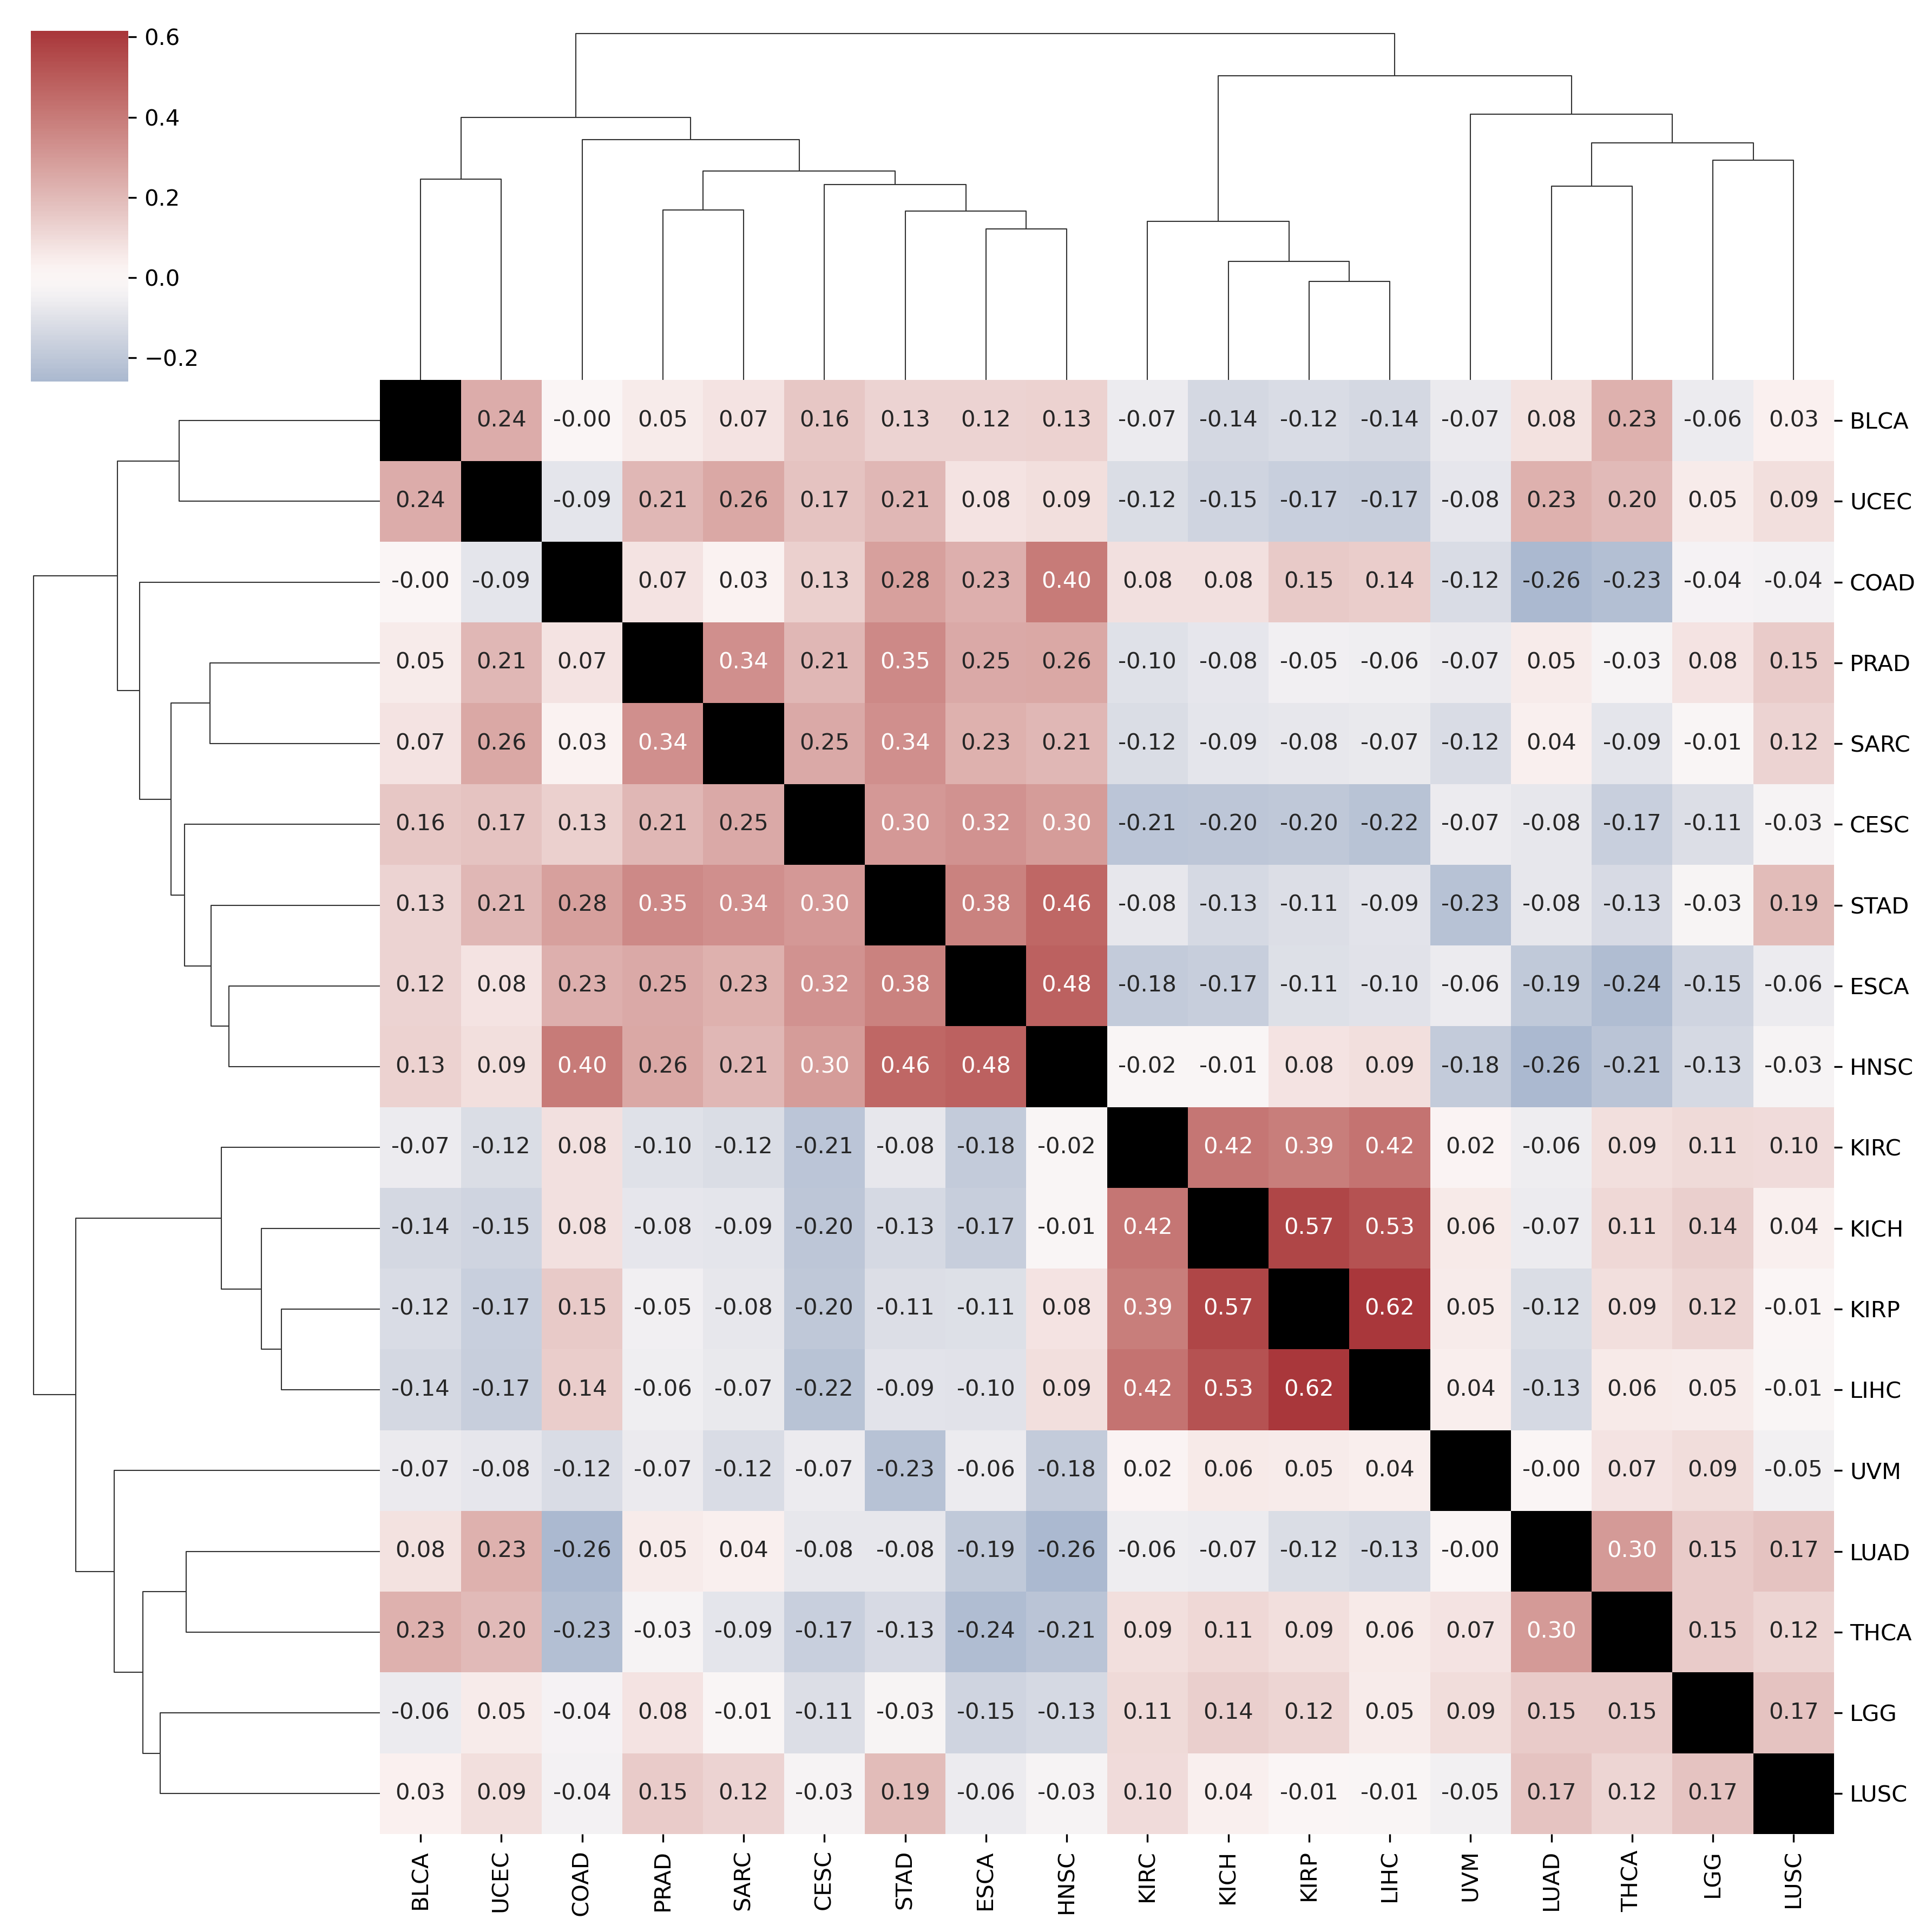

In [14]:
g = sns.clustermap(
    corr,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    figsize=(12, 12),
    mask=mask,
    #dendrogram_ratio=0.2
)
g.ax_heatmap.set_facecolor("black")

plt.savefig("../figures/tcga/cancer_diff_correlation_clustermap.pdf")
plt.show()

In [15]:
summ_diff_std = summ_diff.filter(like="std")
summ_diff_std.head()

,BLCA_std,CESC_std,COAD_std,ESCA_std,HNSC_std,KICH_std,KIRC_std,KIRP_std,LGG_std,LIHC_std,LUAD_std,LUSC_std,PRAD_std,SARC_std,STAD_std,THCA_std,UCEC_std,UVM_std
Feature,,,,,,,,,,,,,,,,,,
G900499005,1.631995,2.789242,2.169901,2.315219,1.491516,3.249919,3.205953,3.167679,3.020839,3.198119,1.960178,3.425180,2.788185,3.269329,1.832221,1.815179,1.742918,3.259464
G900065875,1.585407,1.374392,1.614753,2.169072,1.332133,2.954570,2.050776,2.203144,2.825641,2.287738,2.554884,3.144933,1.739629,1.967071,1.650262,2.490340,1.401786,3.032100
G000174815,1.663828,1.423816,1.680250,2.311689,1.341890,2.155158,1.849627,2.139623,2.675985,2.195904,1.756522,2.120694,1.730337,1.925147,1.559962,1.690735,1.469910,2.957760
G000972495,2.868001,1.800801,2.093655,3.075425,1.798153,2.192139,2.147101,2.129793,3.239188,2.254627,2.979796,3.169553,3.189664,1.924776,2.808369,2.062835,1.518983,3.296932
G000321005,1.568891,1.422612,1.677977,2.354501,1.346874,2.131953,2.014987,2.078378,2.619879,2.116244,1.832443,2.257756,1.887568,1.943499,1.652887,1.767627,1.464082,3.114847


In [16]:
tbl_df = tbl.to_dataframe(dense=True).T
table_clr = pd.DataFrame(clr(tbl_df.values + 1), index=tbl_df.index, columns=tbl_df.columns)

In [17]:
def log_ratio(table, top_feats, bot_feats):
    num_sum = table.loc[:, top_feats].sum(axis=1)
    denom_sum = table.loc[:, bot_feats].sum(axis=1)
    lr_df = pd.concat([num_sum, denom_sum], axis=1)
    lr_df.columns = ["num", "denom"]
    #lr_df = lr_df.dropna(how="all")
    lr_df = lr_df + 1
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"]).to_frame()
    return lr_df

In [18]:
def balance(table, top_feats, bot_feats):
    numerator = np.log(table.loc[:, top_feats] + 1)
    denominator = np.log(table.loc[:, bot_feats] + 1)
    balance = numerator.mean(axis=1) - denominator.mean(axis=1)
    balance.name = "log_ratio"
    return balance.to_frame()

In [19]:
from evident.stats import calculate_cohens_d

def get_predictor_df(n=100):
    predictors = []
    lr_df_dict = dict()

    for invest in investigations:
        col = summ_diff_cent[invest + "_mean"].sort_values(ascending=False)
        top_n = col.head(n).index
        bot_n = col.tail(n).index
        lr = log_ratio(tbl_df, top_n, bot_n)["log_ratio"]
        #lr = balance(tbl_df, top_n, bot_n)["log_ratio"]
        lr.name = invest

        _df = md[["investigation"]].assign(log_ratio=lr)
        lr_df_dict[invest] = lr
        _x = _df.query("investigation != @invest")["log_ratio"]
        _y = _df.query("investigation == @invest")["log_ratio"]
        t, p = ss.ttest_ind(_y, _x, alternative="greater")
        print(
            invest,
            f"{t = }, {p = }",
            calculate_cohens_d(_y, _x),
            "BOOP" if p > 0.05 else ""
        )
        predictors.append(lr)

    return pd.concat(predictors, axis=1).join(md[["investigation", "data_submitting_center_label"]]), lr_df_dict

In [20]:
predictor_df, lr_df_dict = get_predictor_df(140)

PRAD t = 2.9883938562854375, p = 0.0014327543161597007 0.29079102379688304 
UCEC t = 10.339925950111116, p = 2.670041003659917e-24 1.009933825121867 
THCA t = 7.165301460718708, p = 7.016218114945872e-13 0.7473415333547356 
HNSC t = 14.846506858653402, p = 5.848009430131888e-46 1.6153761873382022 
BLCA t = 15.80800418054006, p = 2.839362001410689e-51 1.8554405943608274 
STAD t = 12.58872315045481, p = 2.1749522357282156e-34 1.5435527590227271 
LUAD t = 11.663607569483647, p = 4.711477591238449e-30 1.5124745931021413 
CESC t = 11.228378833219425, p = 4.216238565942563e-28 1.5660709862325015 
LGG t = 4.827656259480746, p = 7.862436778499907e-07 0.6733342819810059 
KICH t = 10.871580284743246, p = 1.5188892126723043e-26 1.7097694678944153 
COAD t = 9.481555870781122, p = 7.196494772701763e-21 1.508539225957192 
LIHC t = 11.575358781787369, p = 1.1845409269327937e-29 1.93509362650667 
ESCA t = 13.009209231010837, p = 1.9307053963037838e-36 2.2986069157461033 
KIRC t = 10.545620333968591, p

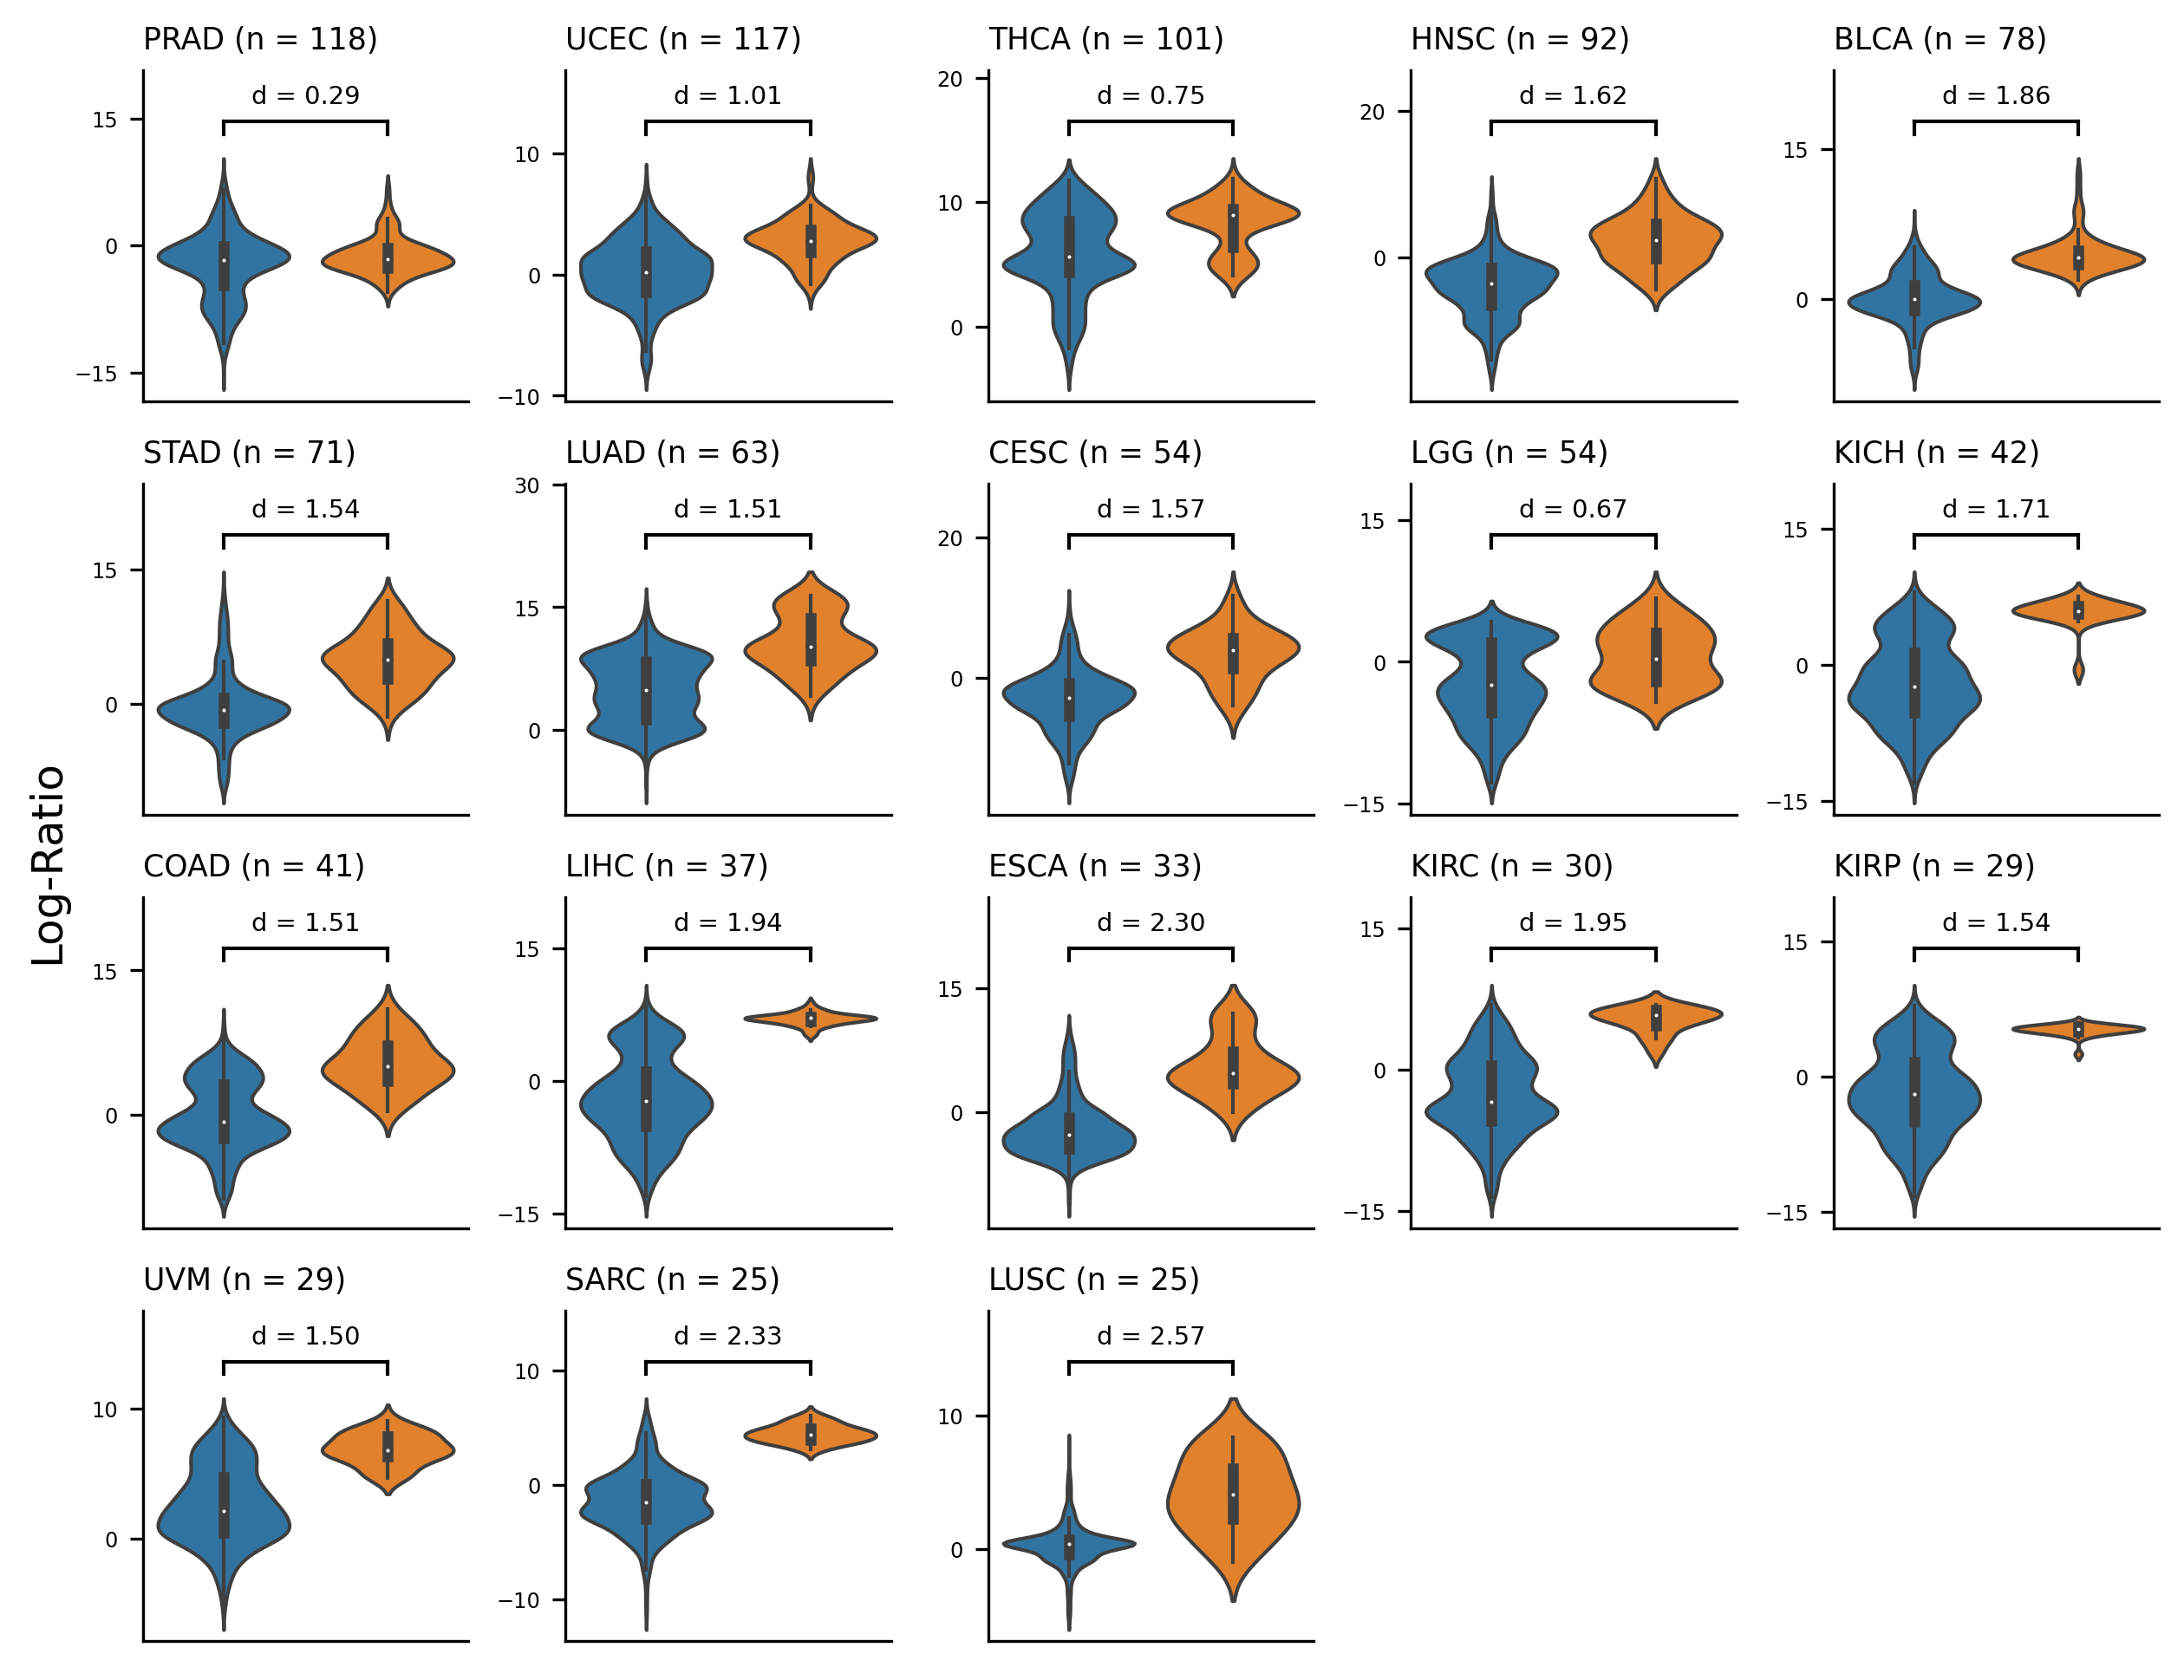

In [21]:
from matplotlib import ticker

fig = plt.figure(figsize=(10, 8))

for i, (invest, _lr) in enumerate(lr_df_dict.items(), start=1):
    ax = fig.add_subplot(4, 5, i)
    _df = pd.concat([_lr, md[["investigation", "data_submitting_center_label"]]], axis=1)
    _df["is_invest"] = _df["investigation"] == invest
    sns.violinplot(
        data=_df,
        x="is_invest",
        y=invest,
        linewidth=1,
        scale="width",
        ax=ax
    )
    ax.xaxis.set_visible(False)
    ax.set_ylabel("")
    ax.tick_params("y", labelsize="xx-small")
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim([ymin, ymax+yrange*0.3])
    
    bot_loc = ymax+yrange*0.05
    top_loc = ymax+yrange*0.1
    ax.plot([0, 1], [top_loc, top_loc], color="k", lw=1)
    ax.plot([0, 0], [bot_loc, top_loc], color="k", lw=1)
    ax.plot([1, 1], [bot_loc, top_loc], color="k", lw=1)
    
    _x = _df.query("is_invest == True")[invest]
    _y = _df.query("is_invest == False")[invest]
    d = calculate_cohens_d(_x, _y)
    ax.text(
        x=0.5,
        y=ymax+yrange*0.15,
        s=f"d = {d:.2f}",
        va="bottom",
        ha="center",
        fontsize="x-small"
    )
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.set_title(f"{invest} (n = {len(_x)})", fontsize="small")

plt.subplots_adjust(wspace=0.3, hspace=0.25)
fig.supylabel("Log-Ratio", x=0.08)

plt.savefig("../figures/tcga/per_cancer_lr_violin.pdf")
plt.show()

In [22]:
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    fit_intercept=True,
    C=1
)

In [23]:
from sklearn.model_selection import StratifiedKFold

new_cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1)

scorer = make_scorer(balanced_accuracy_score, adjusted=False)
scoring = {"balanced_accuracy": scorer, "f1_weighted": "f1_weighted"}

In [24]:
to_join = pd.get_dummies(md[["race", "gender"]])
to_join

,race_ASIAN,race_BLACK OR AFRICAN AMERICAN,race_WHITE,gender_FEMALE,gender_MALE
sampleid,,,,,
S13722.58cfa82de4b0c9d6adf6a502,0,0,1,1,0
S13722.58cfa82de4b0c9d6adf6a4ce,1,0,0,1,0
S13722.58cfa82de4b0c9d6adf6a48a,0,0,1,1,0
S13722.58cfa82de4b0c9d6adf6a4d4,0,1,0,1,0
S13722.58cfa82de4b0c9d6adf6a529,0,0,1,1,0
...,...,...,...,...,...
S13722.58cfa831e4b0c9d6adf6ca3c,0,0,1,0,1
S13722.58cfa831e4b0c9d6adf6cc92,0,0,1,0,1
S13722.58cfa832e4b0c9d6adf6ceda,0,0,1,0,1


In [25]:
md.describe(include=[object]).T.query("1 < unique < 10")

,count,unique,top,freq
gender,1124,2,FEMALE,576
race,1124,3,WHITE,937
ethnicity,984,2,NOT HISPANIC OR LATINO,959
reference_genome,1124,5,HG19_Broad_variant,792
data_submitting_center_label,1124,5,Harvard Medical School,489
portion_is_ffpe,1124,2,NO,1122


In [26]:
md["reference_genome"].value_counts()

HG19_Broad_variant    792
GRCh37-lite           309
HG18                   20
GRCh37                  2
HG18_Broad_variant      1
Name: reference_genome, dtype: int64

In [27]:
md.groupby(["reference_genome", "data_submitting_center_label"]).size()

reference_genome    data_submitting_center_label                      
GRCh37              Harvard Medical School                                  2
GRCh37-lite         Baylor College of Medicine                            174
                    Washington University School of Medicine              135
HG18                Harvard Medical School                                 20
HG18_Broad_variant  Harvard Medical School                                  1
HG19_Broad_variant  Broad Institute of MIT and Harvard                    159
                    Harvard Medical School                                466
                    MD Anderson - Institute for Applied Cancer Science    167
dtype: int64

## BIRDMAn Log-Ratios

Use 140

In [28]:
birdman_scores = dict()

for center, _df in predictor_df.groupby("data_submitting_center_label"):
    X = _df[investigations].join(to_join)
    y = LabelEncoder().fit_transform(_df["investigation"])
    scores = cross_validate(model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
    birdman_scores[center] = scores
    print(center)
    print(len(np.unique(y)))
    print(scores["test_f1_weighted"].mean(), scores["test_balanced_accuracy"].mean())
    print("=======================")

Baylor College of Medicine
6
0.7645577500882698 0.7616558490242702
Broad Institute of MIT and Harvard
9
0.7048204891989729 0.6446463086659165
Harvard Medical School
11
0.7768989338833897 0.7496814687654608
MD Anderson - Institute for Applied Cancer Science
7
0.8404188136651236 0.7308373620580608
Washington University School of Medicine
4
0.821129516283334 0.792315148087207


## CLR Random Forest

In [29]:
rf_model = RandomForestClassifier(random_state=63, n_estimators=100)
rf_scores = dict()

for center, _df in md.groupby("data_submitting_center_label"):
    idx = _df.index
    
    # Remove feats with all zeros before performing CLR
    X = tbl_df.loc[idx]
    non_zero = tbl_df.loc[idx].any()
    ids_to_keep = non_zero[non_zero]
    X = X.loc[:, non_zero]
    X = pd.DataFrame(clr(X.values + 1), index=X.index, columns=X.columns)
    X = X.join(to_join)
    
    y = LabelEncoder().fit_transform(_df.loc[idx]["investigation"])
    scores = cross_validate(rf_model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
    rf_scores[center] = scores
    print(X.shape)
    print(center)
    print(len(np.unique(y)))
    print(scores["test_f1_weighted"].mean(), scores["test_balanced_accuracy"].mean())
    print("=======================")

(174, 1355)
Baylor College of Medicine
6
0.7512712513003108 0.744541481909903
(159, 1284)
Broad Institute of MIT and Harvard
9
0.5915111241653555 0.5228997509389666
(489, 1363)
Harvard Medical School
11
0.6800905413369911 0.6000600635640162
(167, 1249)
MD Anderson - Institute for Applied Cancer Science
7
0.7135323323368976 0.5869104005238459
(135, 1352)
Washington University School of Medicine
4
0.7170599332444569 0.6378347816399288


In [30]:
birdman_score_df = pd.DataFrame.from_dict(birdman_scores)
birdman_score_df = (
    birdman_score_df
    .apply(pd.Series.explode)
    .reset_index()
    .rename(columns={"index": "metric"})
    .melt(id_vars=["metric"], var_name="center")
    .assign(model="BIRDMAn")
)
birdman_score_df.head()

,metric,center,value,model
0,fit_time,Baylor College of Medicine,0.240198,BIRDMAn
1,fit_time,Baylor College of Medicine,0.234633,BIRDMAn
2,fit_time,Baylor College of Medicine,0.230936,BIRDMAn
3,fit_time,Baylor College of Medicine,0.202795,BIRDMAn
4,fit_time,Baylor College of Medicine,0.233133,BIRDMAn


In [31]:
rf_score_df = pd.DataFrame.from_dict(rf_scores)
rf_score_df = (
    rf_score_df
    .apply(pd.Series.explode)
    .reset_index()
    .rename(columns={"index": "metric"})
    .melt(id_vars=["metric"], var_name="center")
    .assign(model="Random Forest")
)
rf_score_df.head()

,metric,center,value,model
0,fit_time,Baylor College of Medicine,0.202981,Random Forest
1,fit_time,Baylor College of Medicine,0.20006,Random Forest
2,fit_time,Baylor College of Medicine,0.199311,Random Forest
3,fit_time,Baylor College of Medicine,0.203746,Random Forest
4,fit_time,Baylor College of Medicine,0.198721,Random Forest


In [32]:
invest_count_per_center = dict(md.groupby(["data_submitting_center_label"]).apply(lambda x: len(x["investigation"].unique())))

In [33]:
all_score_df = pd.concat([birdman_score_df, rf_score_df])
all_score_df["metric"] = all_score_df["metric"].replace({
    "test_f1_weighted": "Classifier F1 Score",
    "test_balanced_accuracy": "Classifier Accuracy"
})

def add_num_cancer_types(center):
    return f"{center}\n({invest_count_per_center[center]} Cancer Types)"

def add_num_samples(center):
    return md.query("data_submitting_center_label == @center").shape[0]

all_score_df["N"] = all_score_df["center"].map(add_num_samples)
all_score_df["center"] = all_score_df["center"].map(add_num_cancer_types)
all_score_df.head()

,metric,center,value,model,N
0,fit_time,Baylor College of Medicine\n(6 Cancer Types),0.240198,BIRDMAn,174
1,fit_time,Baylor College of Medicine\n(6 Cancer Types),0.234633,BIRDMAn,174
2,fit_time,Baylor College of Medicine\n(6 Cancer Types),0.230936,BIRDMAn,174
3,fit_time,Baylor College of Medicine\n(6 Cancer Types),0.202795,BIRDMAn,174
4,fit_time,Baylor College of Medicine\n(6 Cancer Types),0.233133,BIRDMAn,174


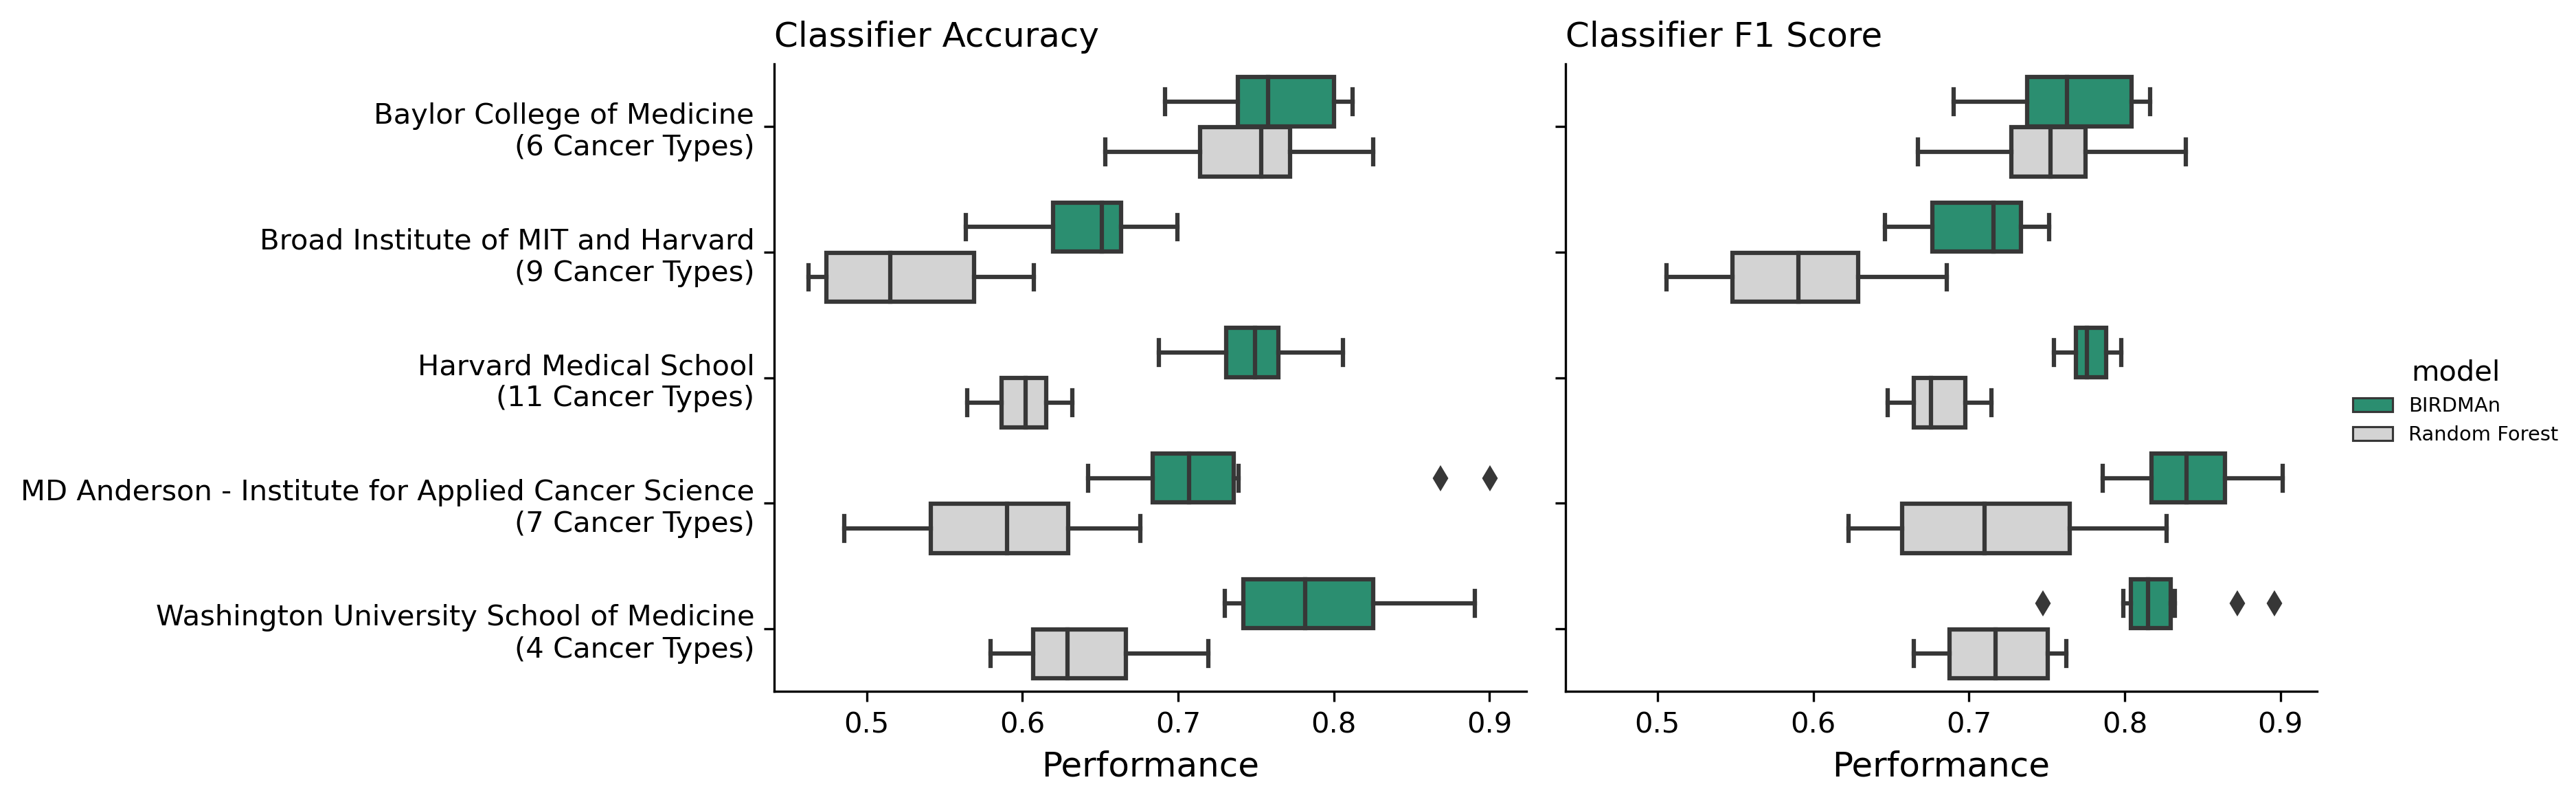

In [34]:
from helper import tool_palette, tool_text_styling_dict

tool_palette["Random Forest"] = "lightgray"

g = sns.catplot(
    data=all_score_df[all_score_df["metric"].str.contains("Classifier")],
    col="metric",
    x="value",
    y="center",
    hue="model",
    palette=tool_palette,
    kind="box",
    height=4,
    aspect=1.5,
)

g.set_ylabels("")
g.set_xlabels("Performance")
g.set_titles(col_template="{col_name}")

plt.savefig("../figures/tcga/per_center_classifier_perf.pdf")
plt.show()